# Train XGBoost model

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from pathlib import Path

In [2]:
import xgboost as xgb

In [3]:
import os
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/hh_micro_mono/")
os.chdir(root_dir / "DMR_classifier")

In [4]:
adata = sc.read_h5ad("dmr_regions-CGN_posterior_frac.h5ad")
metadata = pd.read_csv("dmr_regions-CGN_hypo_score-meta_sub_200.tsv", sep="\t", header=0, index_col=0)

In [6]:
(adata.obs_names == metadata.index).all()

True

In [7]:
included_ct = [
    "CA", "DG", "SUB", "PVALB", "SST", "VIP", "NR2F2-LAMP5",
    "Astro", "Oligo", "OPC", "Endo-VLMC",
    "Endo_Lym_Skn", "Fibro_Mus", "Mast_Skn", "Mono2",
    "NK_CD16_Bld", "Tnaive_CD4_1", "infant_MGC-1"
]

In [8]:
micro_adata = adata[metadata[metadata["celltype"].isin(["Micro1", "Micro2"])].index, :].copy()
adata = adata[metadata[metadata["celltype"].isin(included_ct)].index, :].copy()

In [9]:
adata

AnnData object with n_obs × n_vars = 2648 × 601220
    obs: 'allc_path', 'celltype'
    var: 'chrom', 'end', 'start'

In [10]:
micro_adata

AnnData object with n_obs × n_vars = 300 × 601220
    obs: 'allc_path', 'celltype'
    var: 'chrom', 'end', 'start'

# Initial training

In [11]:
X = adata.X
y = metadata.loc[adata.obs_names, "celltype"].values
le = LabelEncoder()
y_numeric = le.fit_transform(y)

In [12]:
le.classes_

array(['Astro', 'CA', 'DG', 'Endo-VLMC', 'Endo_Lym_Skn', 'Fibro_Mus',
       'Mast_Skn', 'Mono2', 'NK_CD16_Bld', 'NR2F2-LAMP5', 'OPC', 'Oligo',
       'PVALB', 'SST', 'SUB', 'Tnaive_CD4_1', 'VIP', 'infant_MGC-1'],
      dtype=object)

In [13]:
# Train: Eval: Test in 7:2:1 ratio
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_numeric, test_size=0.1, random_state=42, stratify=y_numeric
)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_temp, y_temp, test_size=2/9, random_state=42, stratify=y_temp
)

In [14]:
# Load data onto XGBoost GPU support
dtrain = xgb.DMatrix(X_train, label=y_train)
deval = xgb.DMatrix(X_eval, label=y_eval)
dtest = xgb.DMatrix(X_test, label=y_test)

In [15]:
## Accuracy calculation
num_classes = len(np.unique(y_numeric))
def accuracy_eval(preds, dmatrix):
    labels = dmatrix.get_label().astype(int)
    preds = preds.reshape(-1, num_classes)
    pred_labels = np.argmax(preds, axis=1)
    acc = np.mean(pred_labels == labels)
    return "accuracy", acc

In [16]:
print(num_classes)

18


In [17]:
print(len(metadata["celltype"].unique()))

30


In [18]:
params = {
    "objective": "multi:softprob",
    "num_class": num_classes,
    "tree_method": "hist",
    "device": "cuda",
    "max_depth": 4,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.4,
    "reg_lambda": 1.0,
    "reg_alpha": 0.1,
    "eval_metric": "mlogloss",
    "random_state": 42
}

In [ ]:
evals = [(dtrain, "train"), (deval, "eval")]
evals_result = {}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    evals=evals,
    custom_metric=accuracy_eval,
    evals_result=evals_result,
    early_stopping_rounds=10000,
    verbose_eval=20
)

In [19]:
eval_logloss = evals_result["eval"]["mlogloss"]
best_iter = int(np.argmin(eval_logloss))
best_score = float(np.min(eval_logloss))

In [27]:
bst.save_model("models/hypo-score_20251012.json")

In [17]:
bst = xgb.Booster()
bst.load_model("models/hypo-score_20251012.json")

In [18]:
best_iter = 9999
y_pred_proba = bst.predict(dtest, iteration_range=(0, best_iter + 1))
y_pred = np.argmax(y_pred_proba, axis=1)

In [19]:
order = included_ct

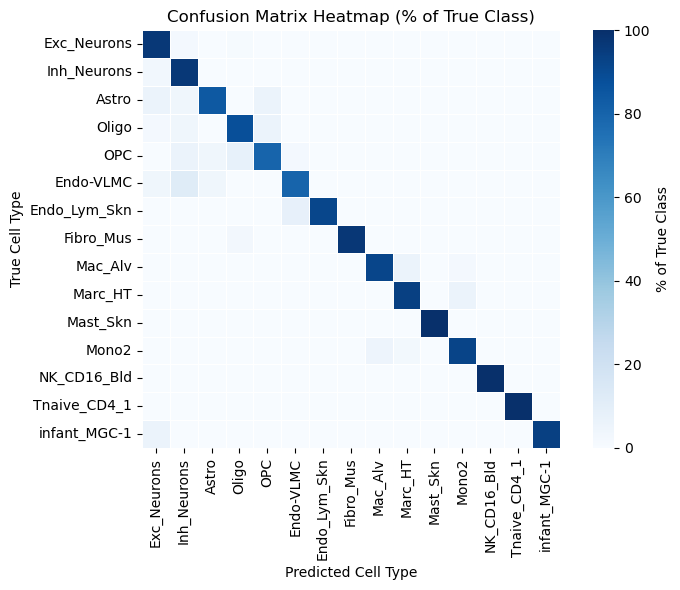

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create heatmap
cm = confusion_matrix(y_test, y_pred, normalize="true") * 100
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df = cm_df.loc[order, order]
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_df,
    cmap="Blues",
    cbar_kws={"label": "% of True Class"},
    square=True,
    annot=False,
    linewidths=0.5
)

plt.title("Confusion Matrix Heatmap (% of True Class)")
plt.xlabel("Predicted Cell Type")
plt.ylabel("True Cell Type")
plt.tight_layout()
plt.show()

In [21]:
dmicro = xgb.DMatrix(micro_adata.X)

In [22]:
micro_pred_prob = bst.predict(dmicro, iteration_range=(0, best_iter + 1))
micro_pred = np.argmax(micro_pred_prob, axis=1)

In [23]:
pred_df = pd.DataFrame({
    "cell_id": micro_adata.obs_names,
    "true_type": metadata.loc[micro_adata.obs_names, "celltype"],
    "predicted_type": le.inverse_transform(micro_pred),
})

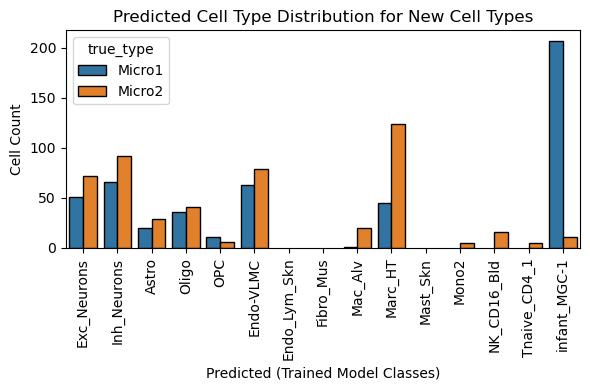

In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(data=pred_df, x="predicted_type", hue="true_type", order=order, edgecolor="black")
plt.title("Predicted Cell Type Distribution for New Cell Types")
plt.xlabel("Predicted (Trained Model Classes)")
plt.ylabel("Cell Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [56]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
proba_df = pd.DataFrame(
    gaussian_filter1d(micro_pred_prob, sigma=1, axis=1, mode="nearest"),
    columns=le.classes_,
    index=micro_adata.obs_names
)
# proba_df = pd.DataFrame(micro_pred_prob, columns=le.classes_)
proba_df["celltype"] = micro_adata.obs["celltype"].values
proba_df["cell_id"] = micro_adata.obs_names.values
proba_long = proba_df.melt(
    id_vars=["cell_id", "celltype"],
    var_name="predicted_class",
    value_name="probability"
)
proba_long["predicted_class"] = pd.Categorical(proba_long["predicted_class"], categories=order)

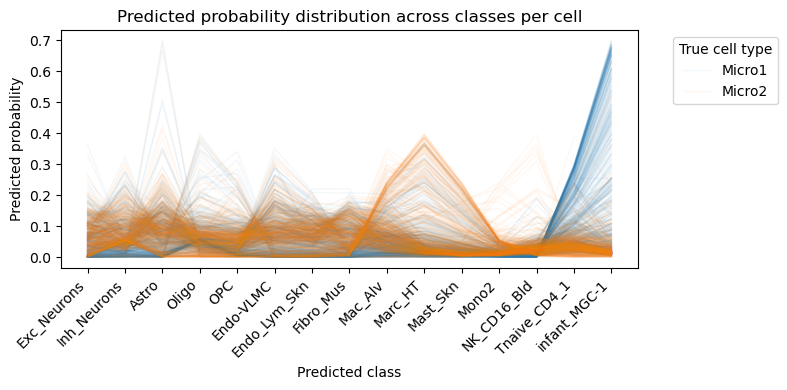

In [60]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=proba_long,
    x="predicted_class",
    y="probability",
    hue="celltype",
    units="cell_id",
    estimator=None,
    lw=1,
    alpha=0.05,
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted probability")
plt.xlabel("Predicted class")
plt.title("Predicted probability distribution across classes per cell")
plt.legend(title="True cell type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Plot models

In [10]:
bst = xgb.Booster()
bst.load_model("models/hypo-score_20251012.json")

In [11]:
importance = bst.get_score(importance_type="gain")
importance_df = (
    pd.DataFrame(list(importance.items()), columns=["feature", "importance"])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

In [12]:
topN = 1000
importance_df["region"] = [adata.var_names[int(f[1:])] for f in importance_df["feature"]]
top_regions = importance_df["region"].head(topN).values

In [15]:
order = included_ct

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

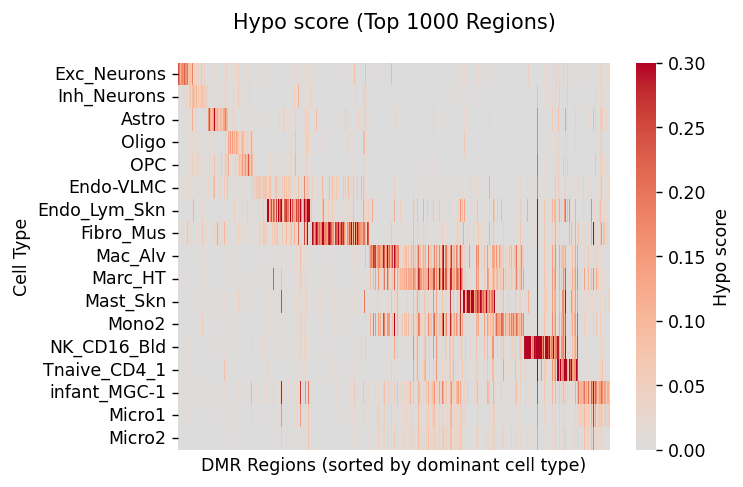

In [27]:
adata.obs["celltype"] = metadata.loc[adata.obs_names, "celltype"]
adata_top = adata[:, top_regions].copy()
adata_top.obs["celltype"] = pd.Categorical(adata_top.obs["celltype"], categories=order, ordered=True)
adata_top = adata_top[adata_top.obs.sort_values("celltype").index, :]

X = adata_top.X.toarray() if hasattr(adata_top.X, "toarray") else adata_top.X
df = pd.DataFrame(X, index=adata_top.obs["celltype"], columns=adata_top.var_names)
mean_by_type = df.groupby(level=0).mean()
dominant_celltype = mean_by_type.idxmax(axis=0)
celltype_order = mean_by_type.index.tolist()
dominant_rank = dominant_celltype.map({ct: i for i, ct in enumerate(celltype_order)})
sorted_columns = (
    mean_by_type.loc[:, dominant_rank.sort_values(kind="stable").index]
    .columns.tolist()
)
mean_sorted = mean_by_type.loc[celltype_order, sorted_columns]

micro_top = micro_adata[:, sorted_columns]
micro_top = micro_top[micro_top.obs.sort_values("celltype").index, :]
X_micro = micro_top.X.toarray() if hasattr(micro_top.X, "toarray") else micro_top.X
df = pd.DataFrame(X_micro, index=micro_top.obs["celltype"], columns=micro_top.var_names)
micro_mean = df.groupby(level=0).mean()
mean_sorted = pd.concat([mean_sorted, micro_mean], axis=0)

# mean_z = (mean_sorted - mean_sorted.mean(axis=1).values[:, None]) / mean_sorted.std(axis=1).values[:, None]

plt.figure(figsize=(6, 4), dpi=125)
sns.heatmap(
    mean_sorted,
    cmap="coolwarm",
    center=0,
    xticklabels=False,
    yticklabels=True,
    cbar_kws={"label": "Hypo score"},
    vmin=0,
    vmax=0.3,
    
)

plt.title("Hypo score (Top {} Regions)".format(topN), pad=20)
plt.xlabel("DMR Regions (sorted by dominant cell type)")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

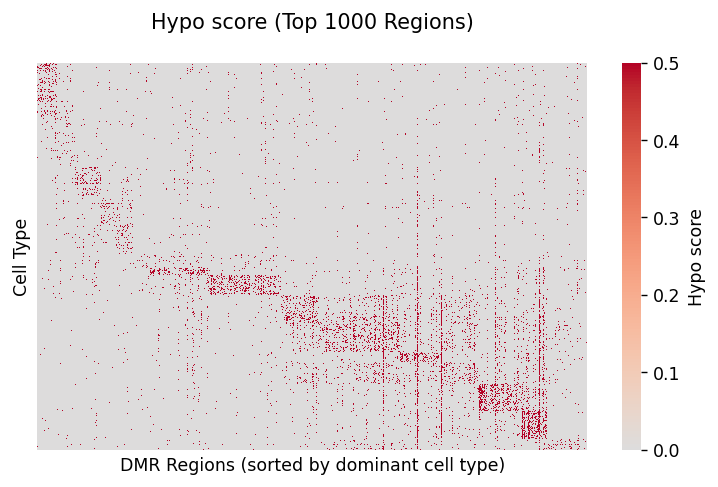

In [16]:
adata_top = adata[:, top_regions].copy()
adata_top.obs["celltype"] = pd.Categorical(adata_top.obs["celltype"], categories=order, ordered=True)
adata_top = adata_top[adata_top.obs.sort_values("celltype").index, :]

X = adata_top.X.toarray() if hasattr(adata_top.X, "toarray") else adata_top.X
df = pd.DataFrame(X, index=adata_top.obs_names, columns=adata_top.var_names)
mean_by_type = df.groupby(adata_top.obs["celltype"]).mean()
dominant_celltype = mean_by_type.idxmax(axis=0)
celltype_order = mean_by_type.index.tolist()
dominant_rank = dominant_celltype.map({ct: i for i, ct in enumerate(celltype_order)})
sorted_columns = (
    mean_by_type.loc[:, dominant_rank.sort_values(kind="stable").index]
    .columns.tolist()
)
mean_sorted = df[sorted_columns]
# mean_z = (mean_sorted - mean_sorted.mean(axis=1).values[:, None]) / mean_sorted.std(axis=1).values[:, None]

plt.figure(figsize=(6, 4), dpi=125)
sns.heatmap(
    mean_sorted,
    cmap="coolwarm",
    center=0,
    xticklabels=False,
    yticklabels=False,
    cbar_kws={"label": "Hypo score"},
    vmin=0,
    vmax=0.5,
    
)

plt.title("Hypo score (Top {} Regions)".format(topN), pad=20)
plt.xlabel("DMR Regions (sorted by dominant cell type)")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

In [17]:
metadata = pd.read_csv("allc_meta.tsv", sep="\t", header=0, index_col=0)
metadata["ct_raw"] = metadata["celltype"].copy()
ext = ["CA", "DG", "SUB"]
metadata.loc[metadata["celltype"].isin(ext), "celltype"] = "Exc_Neurons"
inh = ["PVALB", "SST", "VIP", "NR2F2-LAMP5"]
metadata.loc[metadata["celltype"].isin(inh), "celltype"] = "Inh_Neurons"

In [18]:
from ALLCools.mcds import MCDS

In [19]:
mcds_path = "DMR_CLS.mcds"
var_dim = "dmr_regions"
obs_dim = "cell"
mcds = MCDS.open(mcds_path, obs_dim=obs_dim, var_dim=var_dim)
mcds.add_cell_metadata(metadata)

In [20]:
da = mcds["dmr_regions_da"]
mc = da.sel(mc_type="CGN", count_type="mc")
cov = da.sel(mc_type="CGN", count_type="cov")
mc_bulk = mc.groupby("cell_celltype").sum(dim="cell")
cov_bulk = cov.groupby("cell_celltype").sum(dim="cell")
bulk_beta_sel = 1.0 - mc_bulk.sel(dmr_regions=top_regions) / cov_bulk.sel(dmr_regions=top_regions)

/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 108 times more chunks
  return self.array[key]
/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 108 times more chunks
  return self.array[key]


In [21]:
bulk_beta_sel = bulk_beta_sel.to_pandas()

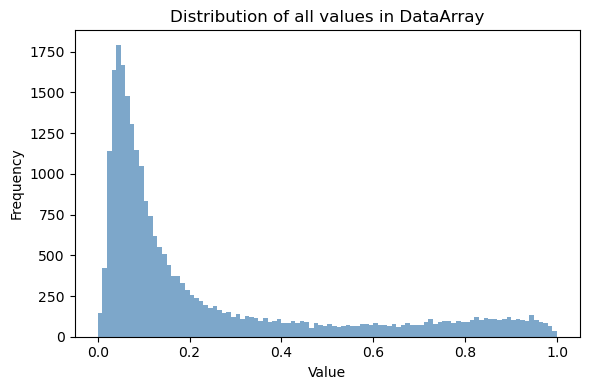

In [22]:
import matplotlib.pyplot as plt

# assume your DataArray is called da
plt.figure(figsize=(6, 4))
plt.hist(bulk_beta_sel.values.ravel(), bins=100, color="steelblue", alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of all values in DataArray")
plt.tight_layout()
plt.show()

In [23]:
df_beta = bulk_beta_sel[bulk_beta_sel.index.isin(order)]
df_beta = df_beta.loc[order, :]
region_order = df_beta.idxmax(axis=0)
region_order = pd.Categorical(region_order, categories=order, ordered=True)
df_beta = df_beta.iloc[:, np.argsort(region_order.codes)]

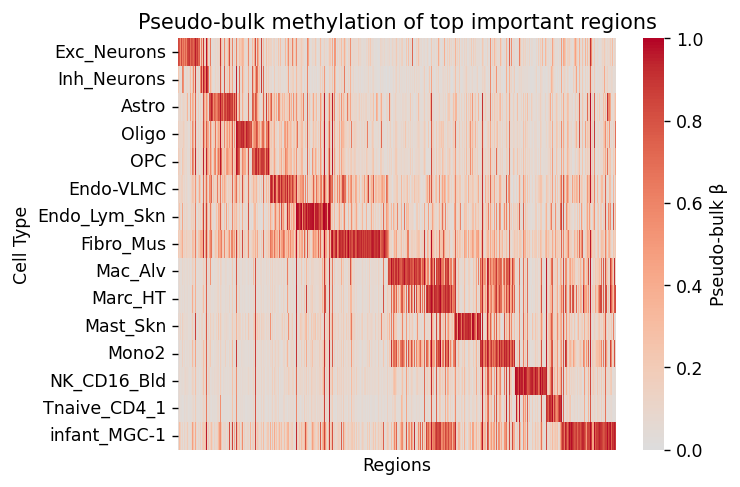

In [25]:
plt.figure(figsize=(6, 4), dpi=125)
sns.heatmap(
    df_beta,
    cmap="coolwarm",
    center=0,
    xticklabels=False,
    vmin=0, 
    vmax=1,
    cbar_kws={"label": "Pseudo-bulk β"},
)
plt.xlabel("Regions")
plt.ylabel("Cell Type")
plt.title("Pseudo-bulk methylation of top important regions")
plt.tight_layout()
plt.show()

In [79]:
meta_sub = pd.read_csv("dmr_regions-CGN_hypo_score-meta_sub.tsv", sep="\t", header=0, index_col=0)
meta_sub["celltype"] = metadata.loc[meta_sub.index, "celltype"].copy()
meta_new_sub = metadata[~metadata.index.isin(meta_sub.index)]
nsample = 500
meta_new_sub = (
    meta_new_sub.groupby("celltype", group_keys=False).
        apply(lambda x: x.sample(n=min(len(x), nsample), random_state=42))
)
meta_new_sub = meta_new_sub[meta_new_sub["celltype"].isin(order)]

In [80]:
mcds_new_sub = mcds.sel(cell=meta_new_sub.index)

In [81]:
test_new = mcds_new_sub.get_score_adata(mc_type="CGN", quant_type="hypo-score")

Loading chunk 0-2822/2822


In [82]:
adata = sc.read_h5ad("dmr_regions-CGN_hypo_score.h5ad")
adata = adata[meta_sub[meta_sub["celltype"].isin(included_ct)].index, :].copy()
X = adata.X
y = meta_sub.loc[adata.obs_names, "celltype"].values
le = LabelEncoder()
y_numeric = le.fit_transform(y)

In [83]:
dtest = xgb.DMatrix(test_new.X, label=le.transform(test_new.obs["celltype"]))
best_iter = 9999
y_pred_proba = bst.predict(dtest, iteration_range=(0, best_iter + 1))
y_pred = np.argmax(y_pred_proba, axis=1)

In [104]:
labels = le.inverse_transform(np.unique(y_pred))

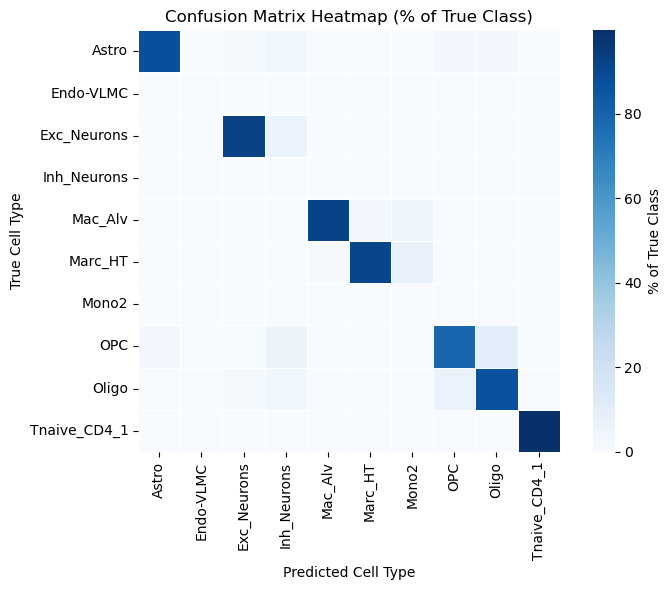

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create heatmap
cm = confusion_matrix(dtest.get_label(), y_pred, normalize="true") * 100
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df.loc[labels, labels]
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_df,
    cmap="Blues",
    cbar_kws={"label": "% of True Class"},
    square=True,
    annot=False,
    linewidths=0.5
)

plt.title("Confusion Matrix Heatmap (% of True Class)")
plt.xlabel("Predicted Cell Type")
plt.ylabel("True Cell Type")
plt.tight_layout()
plt.show()